# Introduction

For this task, we are looking to come up with a solution to predict whether a patient will progress in Chronic Kidney Disease (CKD) staging given their past longitudinal information. With the data at hand, the main complication that sticks out is the time variable, where measurements are taken at irregular time intervals from baseline for each patient. We shall explore two methods to handle this:

Method 1: Use baseline only features

Method 2: Aggregate features across entire time window

In [325]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [326]:
# read in all CSVs
demo = pd.read_csv("T_demo.csv")  # race, gender, age
scr = pd.read_csv("T_creatinine.csv") 
dbp = pd.read_csv("T_DBP.csv")
sbp = pd.read_csv("T_SBP.csv")
hgb = pd.read_csv("T_HGB.csv")
glu = pd.read_csv("T_glucose.csv")
ldl = pd.read_csv("T_ldl.csv")
meds = pd.read_csv("T_meds.csv")
stage = pd.read_csv("T_stage.csv")

In [327]:
# check for nulls 
for i in [demo, scr, dbp, sbp, hgb, glu, ldl, meds, stage]:
    print(i.isnull().values.any())

False
False
False
False
False
False
False
False
False


In [328]:
# view df information and examine for null and zero values
for i in [demo, scr, dbp, sbp, hgb, glu, ldl, meds, stage]:
    print(i.head())
    print(i.info())
    print(i.describe())
    print("\n")

   id     race  gender  age
0   0  Unknown    Male   70
1   1    White  Female   71
2   2    White  Female   57
3   3    White    Male   74
4   4    White  Female   50
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
id        300 non-null int64
race      300 non-null object
gender    300 non-null object
age       300 non-null int64
dtypes: int64(2), object(2)
memory usage: 9.5+ KB
None
               id         age
count  300.000000  300.000000
mean   149.500000   70.383333
std     86.746758    9.247058
min      0.000000   46.000000
25%     74.750000   64.000000
50%    149.500000   71.000000
75%    224.250000   78.000000
max    299.000000   86.000000


   id  value  time
0   0   1.29     0
1   0   1.15   107
2   0   1.44   286
3   0   1.23   382
4   0   1.08   580
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 3 columns):
id       1439 non-null int64
value    1439 non-null float64
tim

#### Conclusion: Looking at the entires, there are no null values, or any zero values that look out of place (for age for example).

## Method 1: Use baseline only features

### Clean and process data

In [329]:
# make sure every df has value at time = 0 for all patients
print("Samples in demographics file: " + str(len(demo)))
print ("Samples in health measurement files (scr, dbp, sbp, hgb, glu, ldl): ")
for i in [scr, dbp, sbp, hgb, glu, ldl]:
    print(len(i[i['time']==0]))

print("Samples in Stage file: " + str(len(stage)))
print("Samples in Prescriptions file: " + str(len(meds)))
# meds file has multiple entires per patient

Samples in demographics file: 300
Samples in health measurement files (scr, dbp, sbp, hgb, glu, ldl): 
300
300
300
300
300
300
Samples in Stage file: 300
Samples in Prescriptions file: 2181


In [330]:
# extract baseline only rows from each measurement dataframe
scr_base = scr[scr['time']==0]
dbp_base = dbp[dbp['time']==0]
sbp_base = sbp[sbp['time']==0]
hgb_base = hgb[hgb['time']==0]
glu_base = glu[glu['time']==0]
ldl_base = ldl[ldl['time']==0]

In [331]:
# for Meds dataframe, we convert any prescription to a binary variable regardless of dosage
meds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2181 entries, 0 to 2180
Data columns (total 5 columns):
id              2181 non-null int64
drug            2181 non-null object
daily_dosage    2181 non-null float64
start_day       2181 non-null int64
end_day         2181 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 85.3+ KB


In [332]:
print(len(meds['drug'].unique()))
meds['drug'].unique()

21


array(['atorvastatin', 'losartan', 'metformin', 'rosuvastatin',
       'pravastatin', 'carvedilol', 'valsartan', 'metoprolol',
       'simvastatin', 'bisoprolol', 'atenolol', 'lovastatin',
       'olmesartan', 'irbesartan', 'canagliflozin', 'dapagliflozin',
       'telmisartan', 'labetalol', 'nebivolol', 'pitavastatin',
       'propranolol'], dtype=object)

In [333]:
# get dummy values for the 21 unique drugs

meds_drug = meds[['id','drug']]
meds_drug

,id,drug
0,0,atorvastatin
1,0,atorvastatin
2,0,losartan
3,0,losartan
4,0,losartan
...,...,...
2176,299,losartan
2177,299,losartan
2178,299,losartan
2179,299,losartan


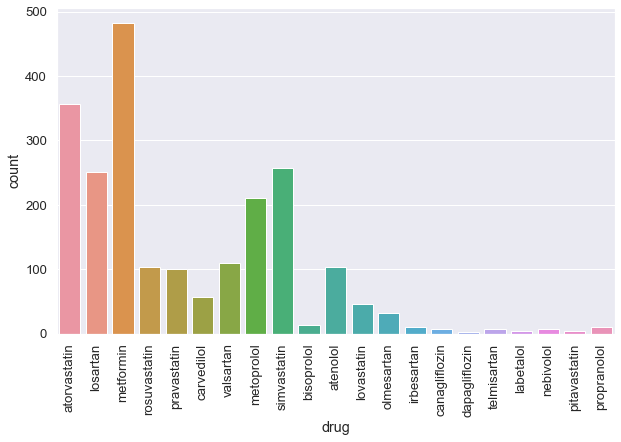

In [334]:
# plot counts for each prescription
plt.figure(figsize=(10,6))
sns.set(font_scale=1.2)
ax = sns.countplot(x='drug', data=meds_drug)
ax.tick_params(axis='x', rotation=90)
plt.savefig('drug_counts.png', dpi=600)

#### Atorvastatin, Iosarta, Metformin and Simvastatin are the four most prescribed drugs in the dataset. Do note that here multiple prescriptions per patient are taken into account for each drug. 

In [335]:
#meds_drug.set_index('id')['drug'].str.get_dummies().max(level=0).reset_index()
meds_drug_dum = meds_drug.set_index('id')['drug'].str.get_dummies().max(level=0).reset_index()
meds_drug_dum

,id,atenolol,atorvastatin,bisoprolol,canagliflozin,carvedilol,dapagliflozin,irbesartan,labetalol,losartan,...,metoprolol,nebivolol,olmesartan,pitavastatin,pravastatin,propranolol,rosuvastatin,simvastatin,telmisartan,valsartan
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,294,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
268,296,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
269,297,0,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
270,298,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [336]:
# some ID entries appear to be missing as only containes 272 rows
missing = []
for i in range(0,299):
    if i not in meds['id'].tolist():
        missing.append(i)
        
print("Patient IDs with no prescription information: " )
print(len(missing))
print(missing)

Patient IDs with no prescription information: 
28
[35, 51, 85, 87, 91, 93, 96, 103, 120, 127, 147, 153, 183, 186, 196, 209, 212, 213, 217, 243, 246, 248, 276, 282, 283, 284, 285, 295]


In [337]:
# insert dummy rows for missing patient IDs in meds 
meds_drug_dum = meds_drug_dum.set_index('id').reindex(range(0,300), fill_value='0').reset_index()
meds_drug_dum

,id,atenolol,atorvastatin,bisoprolol,canagliflozin,carvedilol,dapagliflozin,irbesartan,labetalol,losartan,...,metoprolol,nebivolol,olmesartan,pitavastatin,pravastatin,propranolol,rosuvastatin,simvastatin,telmisartan,valsartan
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,295,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
296,296,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297,297,0,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
298,298,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [338]:
# demo dataframe needs to be converted to dummy values too, have a quick look at the values
demo['race'].unique()

array(['Unknown', 'White', 'Black', 'Asian', 'Hispanic'], dtype=object)

In [339]:
# remove any samples with unknown race
demo_clean = demo.drop(demo[demo.race == 'Unknown'].index)
demo_clean

,id,race,gender,age
1,1,White,Female,71
2,2,White,Female,57
3,3,White,Male,74
4,4,White,Female,50
5,5,Black,Male,73
...,...,...,...,...
294,294,Black,Male,72
295,295,White,Female,79
296,296,White,Female,66
298,298,Asian,Female,72


#### 26 patients were dropped due to having "Unknown" race. This may be too stringent a threshold, and it would be worth exploring leaving it in.

In [340]:
# convert to dummies and replace columns
gender_new = pd.get_dummies(demo_clean['gender'],drop_first=True)
race_new = pd.get_dummies(demo_clean['race'])

In [341]:
demo_clean.drop(['gender','race'],axis=1,inplace=True)

In [342]:
demo_clean = pd.concat([demo_clean, gender_new, race_new], axis=1)
demo_clean.head()

,id,age,Male,Asian,Black,Hispanic,White
1,1,71,0,0,0,0,1
2,2,57,0,0,0,0,1
3,3,74,1,0,0,0,1
4,4,50,0,0,0,0,1
5,5,73,1,0,1,0,0


In [343]:
# convert True/False staging to binary
stage_map = {True: 1, False: 0}
stage['Stage_Progress'] = stage['Stage_Progress'].map(stage_map)
stage.head()

,id,Stage_Progress
0,0,1
1,1,0
2,2,1
3,3,0
4,4,1


In [344]:
# have a look if data is balanced
stage_true_count = len(stage.loc[stage['Stage_Progress'] == True])
stage_false_count = len(stage.loc[stage['Stage_Progress'] == False])
print(stage_true_count, stage_false_count)

100 200


#### There are 100 diseased patients and 200 healthy patients. This may be an imbalanced, and worth keeping in mind when evaluating the models later.

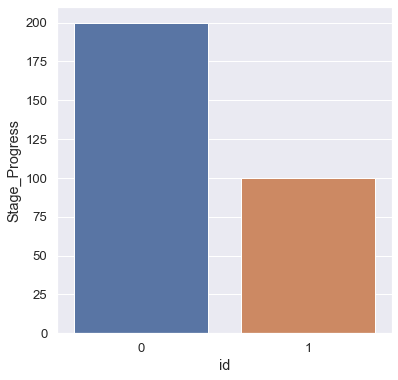

In [345]:
stage_counts = pd.DataFrame(stage['Stage_Progress'].value_counts(), columns=['Stage_Progress'])
stage_counts_index = stage_counts.reset_index()
stage_counts_index.columns = ['id', 'Stage_Progress']

plt.figure(figsize=(6,6))
sns.barplot(x='id', y='Stage_Progress', data=stage_counts_index)
plt.savefig('stage_progress_counts.png', dpi=300)

In [346]:
# merge all files for final dataframe
filelist = [demo_clean, scr_base, dbp_base, sbp_base, hgb_base, glu_base,
            ldl_base, meds_drug_dum, stage]

from functools import reduce

df_baseline = reduce(lambda x,y: pd.merge(x,y, on='id', how='inner'), filelist)
df_baseline

,id,age,Male,Asian,Black,Hispanic,White,value_x,time_x,value_y,...,nebivolol,olmesartan,pitavastatin,pravastatin,propranolol,rosuvastatin,simvastatin,telmisartan,valsartan,Stage_Progress
0,1,71,0,0,0,0,1,1.74,0,72.49,...,0,0,0,0,0,0,0,0,0,0
1,2,57,0,0,0,0,1,2.51,0,81.13,...,0,0,0,0,0,1,0,0,0,1
2,3,74,1,0,0,0,1,0.74,0,80.09,...,0,0,0,0,0,0,0,0,0,0
3,4,50,0,0,0,0,1,1.34,0,82.23,...,0,0,0,1,0,0,0,0,0,1
4,5,73,1,0,1,0,0,1.52,0,81.63,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,294,72,1,0,1,0,0,1.47,0,77.92,...,0,0,0,0,0,0,0,0,0,0
270,295,79,0,0,0,0,1,1.92,0,95.69,...,0,0,0,0,0,0,0,0,0,1
271,296,66,0,0,0,0,1,1.86,0,79.72,...,0,0,0,0,0,0,0,0,0,0
272,298,72,0,1,0,0,0,1.03,0,84.33,...,0,0,0,0,0,0,0,0,0,0


In [347]:
# rename columns
df_baseline.columns

Index(['id', 'age', 'Male', 'Asian', 'Black', 'Hispanic', 'White', 'value_x',
       'time_x', 'value_y', 'time_y', 'value_x', 'time_x', 'value_y', 'time_y',
       'value_x', 'time_x', 'value_y', 'time_y', 'atenolol', 'atorvastatin',
       'bisoprolol', 'canagliflozin', 'carvedilol', 'dapagliflozin',
       'irbesartan', 'labetalol', 'losartan', 'lovastatin', 'metformin',
       'metoprolol', 'nebivolol', 'olmesartan', 'pitavastatin', 'pravastatin',
       'propranolol', 'rosuvastatin', 'simvastatin', 'telmisartan',
       'valsartan', 'Stage_Progress'],
      dtype='object')

In [348]:
# clean up columns and other categorical variables

df_baseline.columns = ['id', 'age', 'Male', 'Asian', 'Black', 'Hispanic', 'White', 
                       'value_scr', 'time_scr', 'value_dbp', 'time_dbp',
                       'value_sbp', 'time_sbp', 'value_hgb', 'time_hgb', 'value_glu', 'time_glu',
                       'value_ldl', 'time_ldl', 'atenolol', 'atorvastatin',
                       'bisoprolol', 'canagliflozin', 'carvedilol', 'dapagliflozin',
                       'irbesartan', 'labetalol', 'losartan', 'lovastatin', 'metformin',
                       'metoprolol', 'nebivolol', 'olmesartan', 'pitavastatin', 'pravastatin',
                       'propranolol', 'rosuvastatin', 'simvastatin', 'telmisartan',
                       'valsartan', 'Stage_Progress']

df_baseline.drop(['time_scr', 'time_dbp', 'time_sbp', 'time_hgb', 'time_glu', 'time_ldl'], axis=1, inplace=True)
df_baseline.head()

,id,age,Male,Asian,Black,Hispanic,White,value_scr,value_dbp,value_sbp,...,nebivolol,olmesartan,pitavastatin,pravastatin,propranolol,rosuvastatin,simvastatin,telmisartan,valsartan,Stage_Progress
0,1,71,0,0,0,0,1,1.74,72.49,157.46,...,0,0,0,0,0,0,0,0,0,0
1,2,57,0,0,0,0,1,2.51,81.13,132.89,...,0,0,0,0,0,1,0,0,0,1
2,3,74,1,0,0,0,1,0.74,80.09,147.46,...,0,0,0,0,0,0,0,0,0,0
3,4,50,0,0,0,0,1,1.34,82.23,128.78,...,0,0,0,1,0,0,0,0,0,1
4,5,73,1,0,1,0,0,1.52,81.63,129.89,...,0,0,0,0,0,1,0,0,0,0


### Exploratory Data Analysis

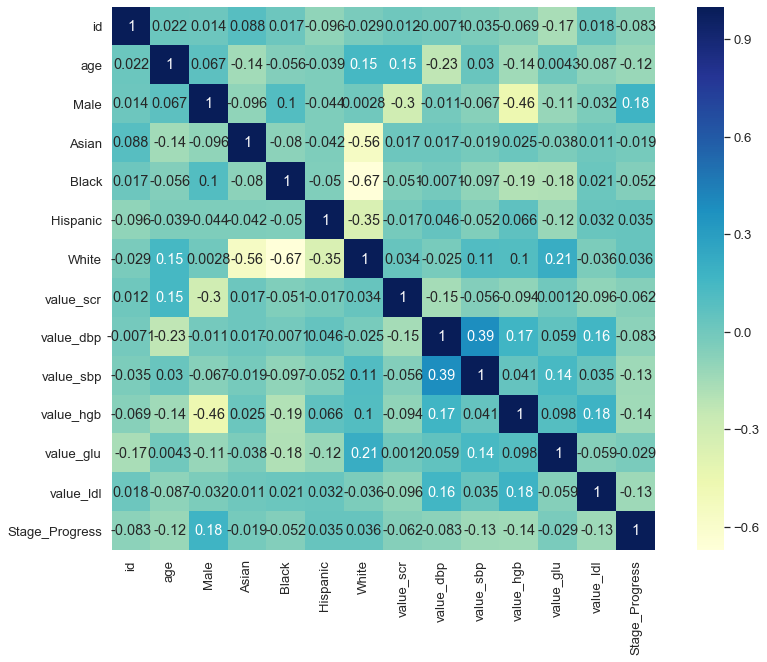

In [349]:
# plot correlation matrix for all variables
corrmat = df_baseline.corr()
top_features = corrmat.index
plt.figure(figsize=(15,10))

g = sns.heatmap(df_baseline[top_features].corr(), annot=True, square=True,cmap="YlGnBu")
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig('baseline_corr.png', dpi=300)

#### There is no major correlation between features, with the highest being the diastolic and systolic blood pressures at 0.39, but this is expected.

In [350]:
# correlation matrix in table form
corrmat

,id,age,Male,Asian,Black,Hispanic,White,value_scr,value_dbp,value_sbp,value_hgb,value_glu,value_ldl,Stage_Progress
id,1.000000,0.021681,0.014445,0.088307,0.017059,-0.095680,-0.029014,0.011802,-0.007105,-0.034776,-0.069208,-0.168105,0.017561,-0.083127
age,0.021681,1.000000,0.067411,-0.143395,-0.055932,-0.039340,0.148928,0.147014,-0.228904,0.029635,-0.137070,0.004340,-0.087484,-0.117455
Male,0.014445,0.067411,1.000000,-0.096107,0.102728,-0.043962,0.002840,-0.300951,-0.010642,-0.067165,-0.456945,-0.112363,-0.032180,0.176770
Asian,0.088307,-0.143395,-0.096107,1.000000,-0.079688,-0.041644,-0.558074,0.016605,0.017471,-0.018813,0.024859,-0.038027,0.011260,-0.018810
Black,0.017059,-0.055932,0.102728,-0.079688,1.000000,-0.050168,-0.672309,-0.050928,-0.007101,-0.096826,-0.192486,-0.183785,0.020834,-0.051766
Hispanic,-0.095680,-0.039340,-0.043962,-0.041644,-0.050168,1.000000,-0.351340,-0.017233,0.046214,-0.051537,0.065832,-0.119644,0.031718,0.034512
White,-0.029014,0.148928,0.002840,-0.558074,-0.672309,-0.351340,1.000000,0.034491,-0.024989,0.105341,0.100051,0.210477,-0.035806,0.036111
value_scr,0.011802,0.147014,-0.300951,0.016605,-0.050928,-0.017233,0.034491,1.000000,-0.154668,-0.055906,-0.093889,0.001159,-0.095681,-0.061768
value_dbp,-0.007105,-0.228904,-0.010642,0.017471,-0.007101,0.046214,-0.024989,-0.154668,1.000000,0.385053,0.167335,0.059036,0.160629,-0.082616
value_sbp,-0.034776,0.029635,-0.067165,-0.018813,-0.096826,-0.051537,0.105341,-0.055906,0.385053,1.000000,0.040874,0.142758,0.035350,-0.131618


Text(0.5, 0, 'age')

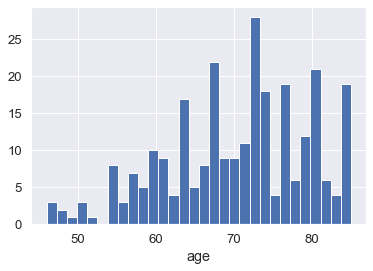

In [351]:
# plot distribution of ages
sns.set_style("darkgrid")
df_baseline['age'].hist(bins=30)
plt.xlabel('age')

In [352]:
# explore correlation between age and stage progression
age_corr = ['age', 'Stage_Progress']
age_corr1 = df_baseline[age_corr]
age_corr_y = df_baseline[df_baseline['Stage_Progress'] == 0].groupby(['age']).size().reset_index(name = 'count')
print("Correlation for healthy patients:")
print(age_corr_y.corr())
print(len(df_baseline[df_baseline['Stage_Progress'] == 0]))

age_corr_y = df_baseline[df_baseline['Stage_Progress'] == 1].groupby(['age']).size().reset_index(name = 'count')
print("\n")
print("Correlation for patients that progress in CKD stage:")
print(age_corr_y.corr())
print(len(df_baseline[df_baseline['Stage_Progress'] == 1]))

Correlation for healthy patients:
            age     count
age    1.000000  0.616693
count  0.616693  1.000000
184


Correlation for patients that progress in CKD stage:
            age     count
age    1.000000  0.455503
count  0.455503  1.000000
90


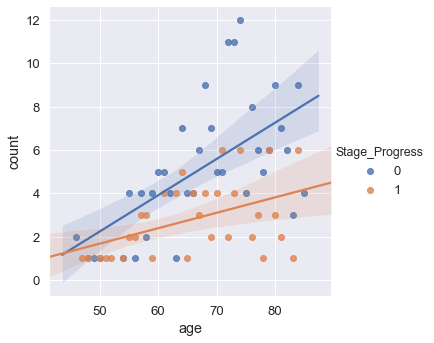

In [353]:
# plot correlation between age and stage progression
age_corr = df_baseline.groupby(['age', 'Stage_Progress']).size().reset_index(name = 'count')
sns.lmplot(data = age_corr, x = 'age', y = 'count', hue="Stage_Progress")

#### The above graph shows that there is a stronger positive correlation between age and stage progression in healthy patients, which is unexpected. This may be due to there being more healthy patients (184) than diseased (90) in the dataset.

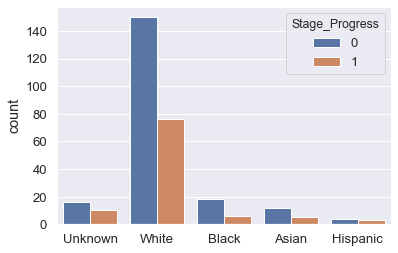

In [354]:
# plot counts for each race in demographics dataframe
demo_stage = pd.merge(demo,stage, on='id', how='inner')

ax = sns.countplot(x="race", hue="Stage_Progress", data=demo_stage)
ax.set(xlabel=None)
plt.savefig('race_stage.png', dpi=300)

#### The above chart shows that the majority of the dataset are records from the White race.

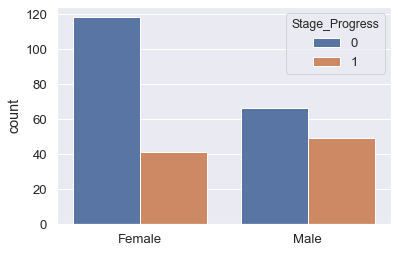

In [355]:
# plot counts for gender grouped by stage progression
demo_clean_forplot = demo.drop(demo[demo.race == 'Unknown'].index)
demo_stage_2 = pd.merge(demo_clean_forplot,stage, on='id', how='inner')

ax = sns.countplot(x="gender", hue="Stage_Progress", data=demo_stage_2)
ax.set(xlabel=None)
plt.savefig('gender_stage.png', dpi=300)

#### The majority of records are from females. There also seems to be a higher proportions of males that are diseased, compared to females.

In [356]:
subset = df_baseline[['id', 'age', 'Male', 'Asian', 'Black', 'Hispanic', 'White',
                      'Stage_Progress']]

subset.head()

,id,age,Male,Asian,Black,Hispanic,White,Stage_Progress
0,1,71,0,0,0,0,1,0
1,2,57,0,0,0,0,1,1
2,3,74,1,0,0,0,1,0
3,4,50,0,0,0,0,1,1
4,5,73,1,0,1,0,0,0


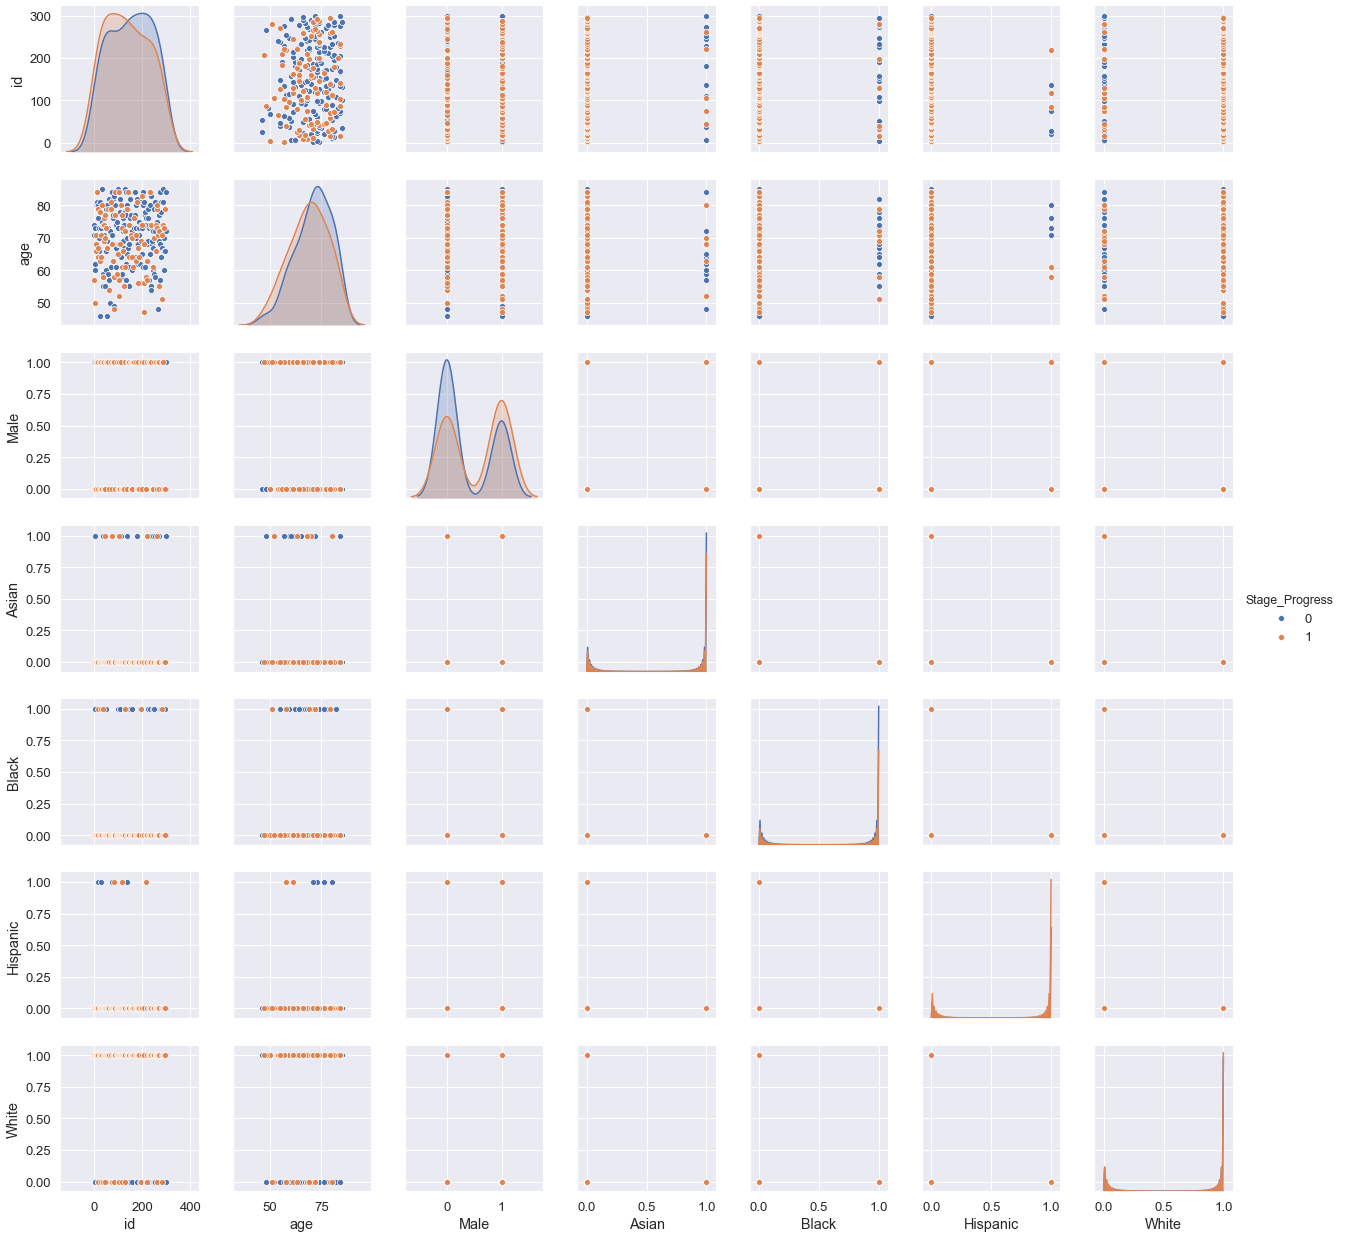

In [357]:
# create pairplots with hue defined by Stage_Progress
sns.pairplot(subset, vars =['id', 'age', 'Male', 'Asian', 'Black', 'Hispanic', 'White'], hue='Stage_Progress')

In [358]:
subset2 = df_baseline[['id', 'value_scr', 'value_dbp', 'value_sbp', 'value_hgb', 'value_glu', 
                      'value_ldl', 'Stage_Progress']]

subset2.head()

,id,value_scr,value_dbp,value_sbp,value_hgb,value_glu,value_ldl,Stage_Progress
0,1,1.74,72.49,157.46,13.89,9.96,89.57,0
1,2,2.51,81.13,132.89,15.34,7.24,61.62,1
2,3,0.74,80.09,147.46,13.74,6.43,99.71,0
3,4,1.34,82.23,128.78,13.21,8.76,65.73,1
4,5,1.52,81.63,129.89,12.03,5.97,57.32,0


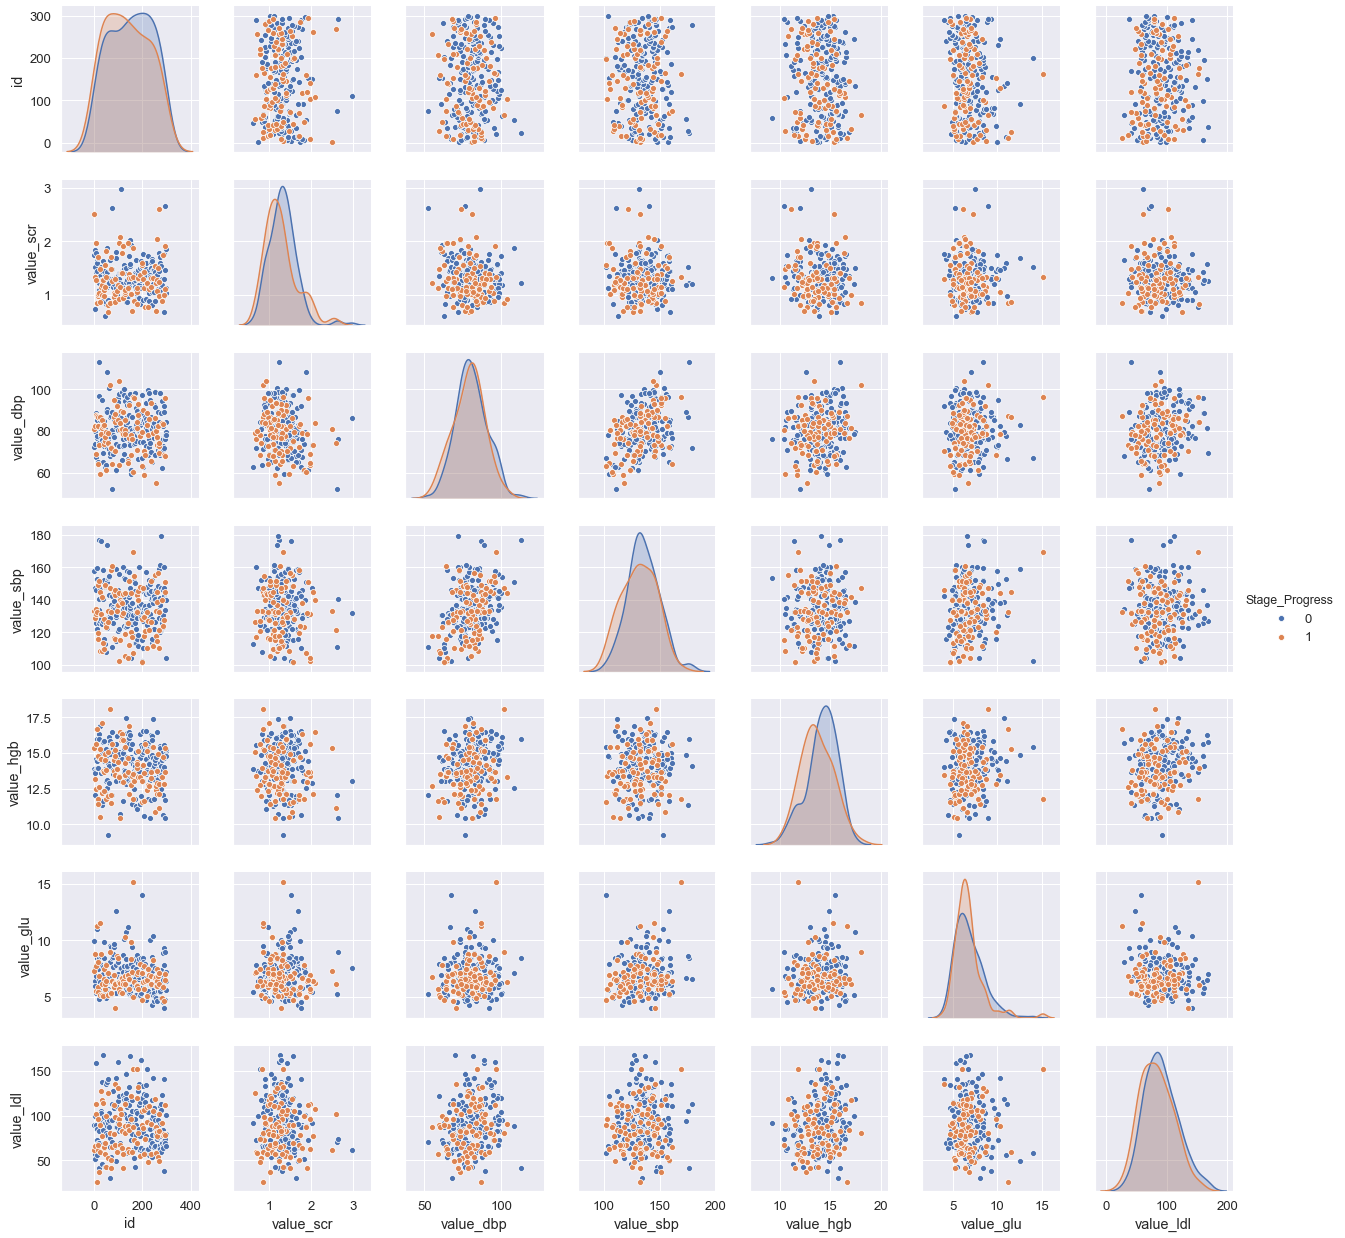

In [359]:
sns.pairplot(subset2, vars = ['id', 'value_scr', 'value_dbp', 'value_sbp', 'value_hgb', 'value_glu', 'value_ldl'], hue='Stage_Progress')
plt.savefig('measurements_stage.png', dpi=300)

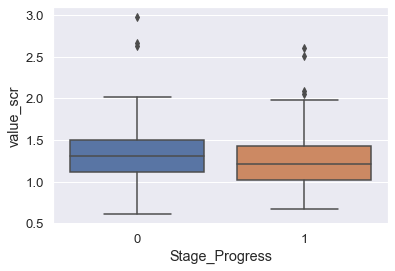

In [360]:
sns.boxplot(x='Stage_Progress', y='value_scr', data=subset2)

## Model fitting (With all variables)

Here, we have chosen to train three models: 

i. Logistic Regression

ii. Decision Tree

iii. Random Forest

### i. Logistic Regression

In [361]:
# import libraries
from sklearn.model_selection import train_test_split

In [362]:
# define X and y
X = df_baseline.drop(['Stage_Progress'], axis=1)
y = df_baseline['Stage_Progress']

In [363]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [364]:
# train and fit logistic regression model
from sklearn.linear_model import LogisticRegression

In [365]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [366]:
# predict from model
predictions = logmodel.predict(X_test)
predictions

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [367]:
# classification report
from sklearn.metrics import classification_report

In [368]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.69      0.95      0.80        38
           1       0.33      0.06      0.10        17

    accuracy                           0.67        55
   macro avg       0.51      0.50      0.45        55
weighted avg       0.58      0.67      0.58        55



In [369]:
print(logmodel.coef_, logmodel.intercept_)

[[-9.36602931e-04 -1.53083063e-02  8.81239013e-01  4.67211079e-01
  -2.06772565e-01  1.11608650e-01  4.73142712e-01  2.20285259e-01
  -5.65077984e-03 -9.90021729e-03  4.89881552e-02  2.90266071e-02
  -6.39820883e-03 -2.15766025e-01 -3.76972844e-01 -5.72573153e-01
  -4.51593472e-01  4.64672261e-01 -5.01993438e-01  8.19890985e-01
   0.00000000e+00 -7.69504592e-02 -6.16460641e-01  4.59852315e-01
   5.70875263e-01  6.45317844e-01 -4.41034041e-01 -3.71824025e-01
   1.45615295e-01 -4.92239173e-01 -4.57369339e-01 -4.45771565e-01
   1.02810959e+00  2.61357200e-01]] [0.84518987]


Feature: 0, Score: -0.00094
Feature: 1, Score: -0.01531
Feature: 2, Score: 0.88124
Feature: 3, Score: 0.46721
Feature: 4, Score: -0.20677
Feature: 5, Score: 0.11161
Feature: 6, Score: 0.47314
Feature: 7, Score: 0.22029
Feature: 8, Score: -0.00565
Feature: 9, Score: -0.00990
Feature: 10, Score: 0.04899
Feature: 11, Score: 0.02903
Feature: 12, Score: -0.00640
Feature: 13, Score: -0.21577
Feature: 14, Score: -0.37697
Feature: 15, Score: -0.57257
Feature: 16, Score: -0.45159
Feature: 17, Score: 0.46467
Feature: 18, Score: -0.50199
Feature: 19, Score: 0.81989
Feature: 20, Score: 0.00000
Feature: 21, Score: -0.07695
Feature: 22, Score: -0.61646
Feature: 23, Score: 0.45985
Feature: 24, Score: 0.57088
Feature: 25, Score: 0.64532
Feature: 26, Score: -0.44103
Feature: 27, Score: -0.37182
Feature: 28, Score: 0.14562
Feature: 29, Score: -0.49224
Feature: 30, Score: -0.45737
Feature: 31, Score: -0.44577
Feature: 32, Score: 1.02811
Feature: 33, Score: 0.26136


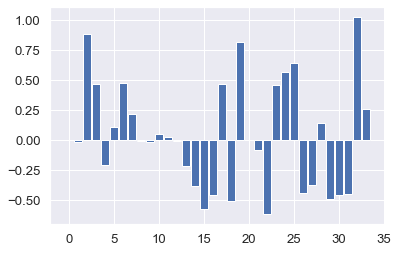

In [370]:
# get importance
importance = logmodel.coef_[0]

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### ii. Decision Tree

In [371]:
from sklearn.tree import DecisionTreeClassifier

In [372]:
dtree = DecisionTreeClassifier()

In [373]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [374]:
predictions = dtree.predict(X_test)

In [375]:
from sklearn.metrics import classification_report,confusion_matrix

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[28 10]
 [11  6]]
              precision    recall  f1-score   support

           0       0.72      0.74      0.73        38
           1       0.38      0.35      0.36        17

    accuracy                           0.62        55
   macro avg       0.55      0.54      0.55        55
weighted avg       0.61      0.62      0.61        55



### iii. Random Forest Classifier

In [376]:
from sklearn.ensemble import RandomForestClassifier

In [377]:
rfc = RandomForestClassifier(n_estimators=200)

In [378]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [379]:
rfc_pred = rfc.predict(X_test)

In [380]:
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))

[[37  1]
 [14  3]]
              precision    recall  f1-score   support

           0       0.73      0.97      0.83        38
           1       0.75      0.18      0.29        17

    accuracy                           0.73        55
   macro avg       0.74      0.58      0.56        55
weighted avg       0.73      0.73      0.66        55



## b. (All variables - drugs)

Let's try to test the model without the prescription information, to see if there is any improvement.

In [381]:
# import libraries
from sklearn.model_selection import train_test_split

In [382]:
# define X and y
X = df_baseline[['id', 'age', 'Male', 'Asian', 'Black', 'Hispanic', 'White', 'value_scr', 
                 'value_dbp', 'value_sbp', 'value_hgb', 'value_glu', 'value_ldl']]
y = df_baseline['Stage_Progress']

In [383]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [384]:
# train and fit logistic regression model
from sklearn.linear_model import LogisticRegression

In [385]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [386]:
# predict from model
predictions = logmodel.predict(X_test)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [387]:
# classification report
from sklearn.metrics import classification_report

In [388]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.71      0.97      0.82        38
           1       0.67      0.12      0.20        17

    accuracy                           0.71        55
   macro avg       0.69      0.55      0.51        55
weighted avg       0.70      0.71      0.63        55



In [389]:
print(logmodel.coef_, logmodel.intercept_)

[[-0.00119997 -0.01548316  0.84034463  0.40073728 -0.24148262  0.26159472
   0.46638079  0.0720775  -0.00254114 -0.00689234  0.03792568  0.00393674
  -0.00717181]] [0.88723017]


Feature: 0, Score: -0.00120
Feature: 1, Score: -0.01548
Feature: 2, Score: 0.84034
Feature: 3, Score: 0.40074
Feature: 4, Score: -0.24148
Feature: 5, Score: 0.26159
Feature: 6, Score: 0.46638
Feature: 7, Score: 0.07208
Feature: 8, Score: -0.00254
Feature: 9, Score: -0.00689
Feature: 10, Score: 0.03793
Feature: 11, Score: 0.00394
Feature: 12, Score: -0.00717


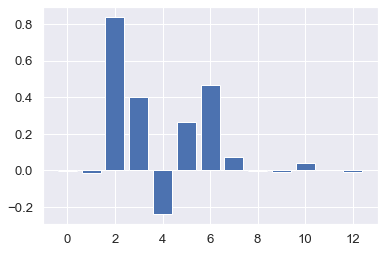

In [390]:
# get importance
importance = logmodel.coef_[0]

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### ii. Decision Tree Classifier 

In [391]:
from sklearn.tree import DecisionTreeClassifier

In [392]:
dtree = DecisionTreeClassifier()

In [393]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [394]:
predictions = dtree.predict(X_test)

In [395]:
from sklearn.metrics import classification_report,confusion_matrix

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[27 11]
 [ 7 10]]
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        38
           1       0.48      0.59      0.53        17

    accuracy                           0.67        55
   macro avg       0.64      0.65      0.64        55
weighted avg       0.70      0.67      0.68        55



### iii. Random Forest Classifier

In [396]:
from sklearn.ensemble import RandomForestClassifier

In [397]:
rfc = RandomForestClassifier(n_estimators=200)

In [398]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [399]:
rfc_pred = rfc.predict(X_test)

In [400]:
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))

[[31  7]
 [12  5]]
              precision    recall  f1-score   support

           0       0.72      0.82      0.77        38
           1       0.42      0.29      0.34        17

    accuracy                           0.65        55
   macro avg       0.57      0.55      0.56        55
weighted avg       0.63      0.65      0.64        55



#### The decision tree classifier appears to be performing the best, but all three models do not have good predictive power for the True class, as shown in their Recall metrics.

## Method 2: Use aggregated features (min, max, median, mean, sd,) across full time frame

In this second method, instead of using just the baseline lab measurements, we first calculate the minimum, maximum, median, mean, and standard deviation using numpy, and then train the model using these new aggregated measurements. 

We will proceed without the prescription information here as the results when using the Baseline datasets show that without the prescriptions there is some improvement.

### Clean and process data

In [401]:
# read in all CSVs
demo = pd.read_csv("T_demo.csv")  # race, gender, age
scr = pd.read_csv("T_creatinine.csv")    # value, time
dbp = pd.read_csv("T_DBP.csv")   # value, time
sbp = pd.read_csv("T_SBP.csv")   # value, time
hgb = pd.read_csv("T_HGB.csv")   # value, time
glu = pd.read_csv("T_glucose.csv")   # value, time
ldl = pd.read_csv("T_ldl.csv")   # value, time
meds = pd.read_csv("T_meds.csv")
stage = pd.read_csv("T_stage.csv")

In [402]:
# create a function to aggregate the lab measurements and create a new processed dataframe
def aggregate(df, name):   
    temp = df.groupby('id').agg([np.mean, np.median, np.min, np.max, np.std]).reset_index()
    temp.columns = temp.columns.droplevel()
    temp.columns = ['id', 'value_mean_{0}'.format(name), 'value_median_{0}'.format(name), 'value_min_{0}'.format(name), 'value_max_{0}'.format(name), 'value_std_{0}'.format(name), 'time_mean', 'time_median', 'time_min', 'time_max_{0}'.format(name), 'time_std']
    temp.drop(['time_mean', 'time_median', 'time_min', 'time_std'], axis=1, inplace=True)
    
    return (temp)

scr_agg = aggregate(scr, 'scr')
dbp_agg = aggregate(dbp, 'dbp')
sbp_agg = aggregate(sbp, 'sbp')
hgb_agg = aggregate(hgb, 'hgb')
glu_agg = aggregate(glu, 'glu')
ldl_agg = aggregate(ldl, 'ldl')

ldl_agg.head()

,id,value_mean_ldl,value_median_ldl,value_min_ldl,value_max_ldl,value_std_ldl,time_max_ldl
0,0,143.593333,157.900,111.39,161.49,27.946610,382
1,1,82.424000,79.020,71.56,98.73,11.520748,660
2,2,75.283333,77.090,61.62,87.14,12.855568,497
3,3,98.246000,99.710,80.80,110.29,10.749676,610
4,4,65.907500,68.495,54.61,72.03,8.037397,574


In [403]:
# convert True/False staging to binary
stage_map = {True: 1, False: 0}
stage['Stage_Progress'] = stage['Stage_Progress'].map(stage_map)
stage.head()

,id,Stage_Progress
0,0,1
1,1,0
2,2,1
3,3,0
4,4,1


In [404]:
# merge all files for final dataframe (without meds)
filelist = [demo_clean, scr_agg, dbp_agg, sbp_agg, hgb_agg, glu_agg,
            ldl_agg, stage]

from functools import reduce

df_agg = reduce(lambda x,y: pd.merge(x,y, on='id', how='inner'), filelist)
df_agg

,id,age,Male,Asian,Black,Hispanic,White,value_mean_scr,value_median_scr,value_min_scr,...,value_max_glu,value_std_glu,time_max_glu,value_mean_ldl,value_median_ldl,value_min_ldl,value_max_ldl,value_std_ldl,time_max_ldl,Stage_Progress
0,1,71,0,0,0,0,1,1.838000,1.810,1.61,...,9.96,0.818138,660,82.424000,79.020,71.56,98.73,11.520748,660,0
1,2,57,0,0,0,0,1,2.170000,2.200,1.89,...,7.24,1.170527,621,75.283333,77.090,61.62,87.14,12.855568,497,1
2,3,74,1,0,0,0,1,0.996000,0.900,0.74,...,7.45,0.838469,682,98.246000,99.710,80.80,110.29,10.749676,610,0
3,4,50,0,0,0,0,1,1.150000,1.115,0.93,...,11.00,0.924193,653,65.907500,68.495,54.61,72.03,8.037397,574,1
4,5,73,1,0,1,0,0,1.613333,1.580,1.52,...,6.47,0.327249,571,66.493333,65.090,57.32,77.07,9.949504,571,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,294,72,1,0,1,0,0,1.414000,1.430,1.13,...,5.87,0.485171,663,69.590000,69.580,57.97,85.00,10.031022,661,0
270,295,79,0,0,0,0,1,1.774000,1.840,1.61,...,6.99,0.959127,646,118.198000,121.510,107.37,126.63,8.245806,623,1
271,296,66,0,0,0,0,1,1.432000,1.380,1.25,...,9.31,0.839899,566,102.960000,100.430,91.09,127.95,14.968300,566,0
272,298,72,0,1,0,0,0,1.116000,1.030,0.97,...,6.42,0.385329,452,78.074000,76.590,62.08,103.21,15.536407,452,0


### Exploratory Data Analysis

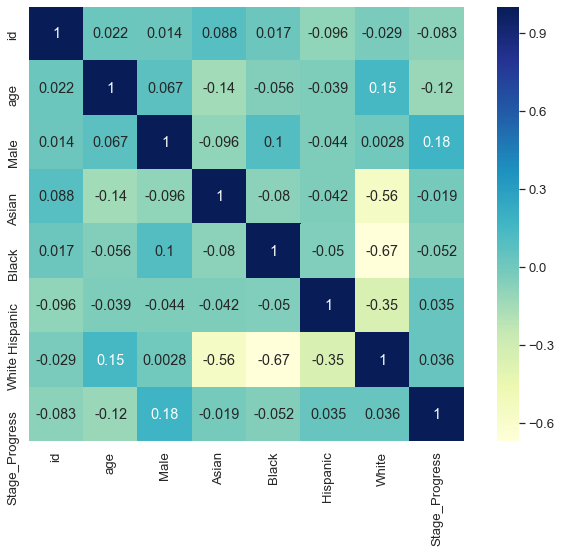

In [405]:
# plot correlation matrix for aggregated dataframe
corrmat = subset.corr()
top_features = corrmat.index
plt.figure(figsize=(12,8))

g = sns.heatmap(subset[top_features].corr(), annot=True, square=True,cmap="YlGnBu")
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig('agg_corr.png', dpi=300)

In [406]:
subset = df_agg[['id', 'value_mean_scr', 'value_mean_dbp', 'value_mean_sbp', 'value_mean_hgb', 'value_mean_glu', 'value_mean_ldl', 
                      'Stage_Progress']]

subset.head()

,id,value_mean_scr,value_mean_dbp,value_mean_sbp,value_mean_hgb,value_mean_glu,value_mean_ldl,Stage_Progress
0,1,1.838000,80.455714,150.232857,13.662857,9.240000,82.424000,0
1,2,2.170000,89.217500,140.210000,15.700000,6.466667,75.283333,1
2,3,0.996000,74.857143,139.588571,13.198000,6.525000,98.246000,0
3,4,1.150000,97.385714,160.667143,12.658000,9.720000,65.907500,1
4,5,1.613333,76.592500,116.760000,11.637500,6.027500,66.493333,0


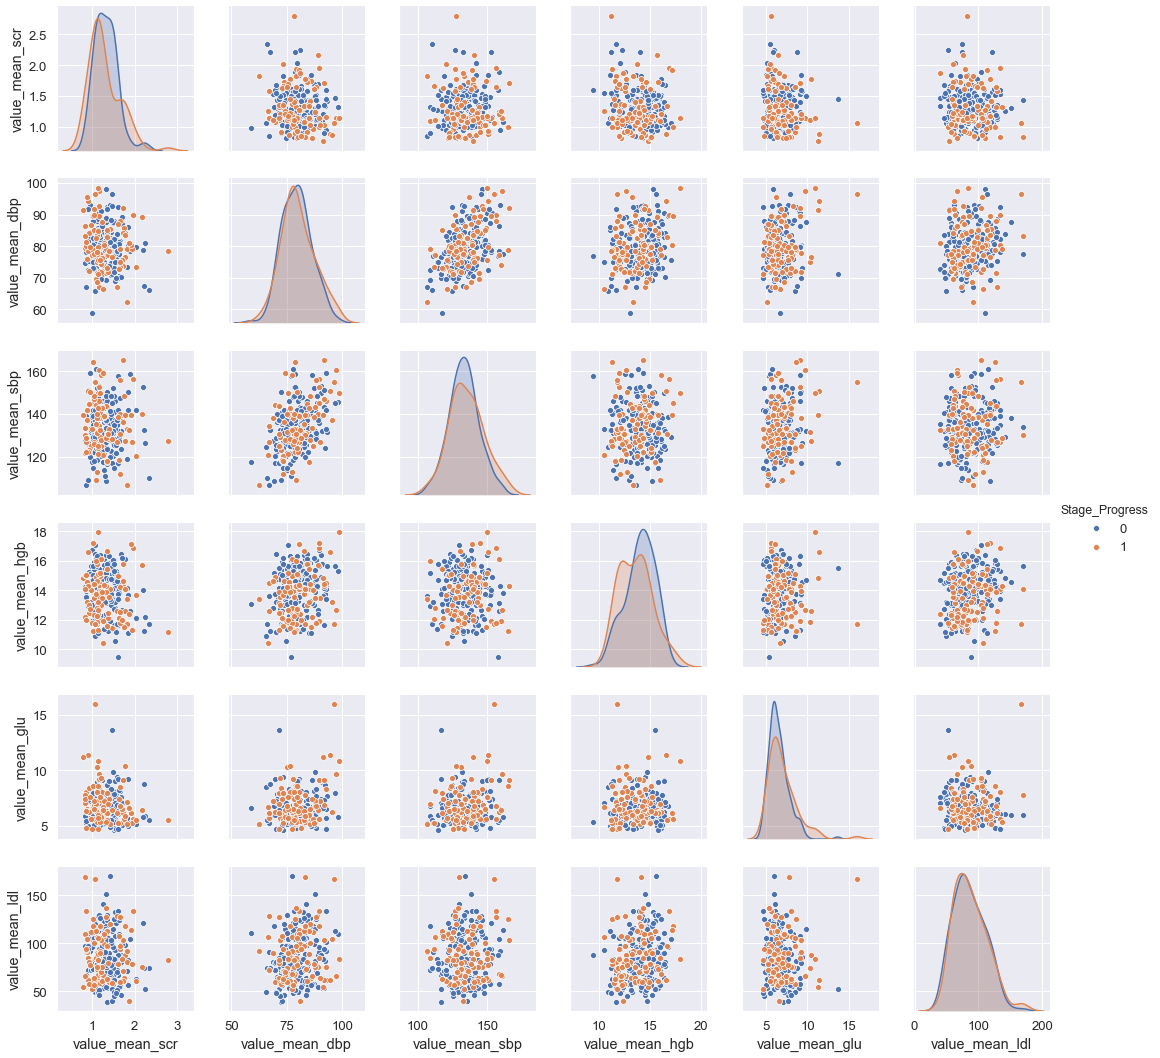

In [407]:
sns.pairplot(subset, vars = ['value_mean_scr', 'value_mean_dbp', 'value_mean_sbp', 'value_mean_hgb', 'value_mean_glu', 'value_mean_ldl'], hue='Stage_Progress')

C:\Users\User\Anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: The handle <matplotlib.patches.Patch object at 0x000001EC752E1CC8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  **kwargs)


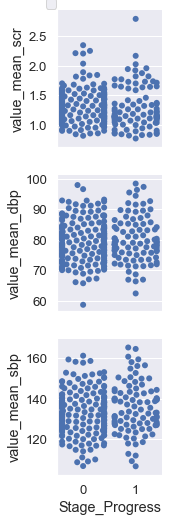

In [408]:
# plot swarmplot to examine lab measurement means between healthy and diseased patients
graph = sns.PairGrid(df_agg,
                 x_vars=['Stage_Progress'],
                 y_vars=['value_mean_scr', 'value_mean_dbp', 'value_mean_sbp'])
graph.map(sns.swarmplot, s = 6)
graph.add_legend(frameon=True, bbox_to_anchor=(0.33, 0.96));

plt.savefig('swarm_lab_1.png', dpi=300)

C:\Users\User\Anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: The handle <matplotlib.patches.Patch object at 0x000001EC11A910C8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  **kwargs)


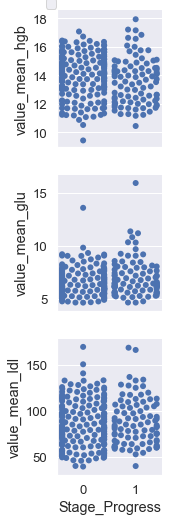

In [409]:
graph = sns.PairGrid(df_agg,
                 x_vars=['Stage_Progress'],
                 y_vars=['value_mean_hgb', 'value_mean_glu', 'value_mean_ldl'])
graph.map(sns.swarmplot, s = 6)
graph.add_legend(frameon=True, bbox_to_anchor=(0.33, 0.96));

plt.savefig('swarm_lab_2.png', dpi=300)

#### These swarmplots show that while there are more records from Healthy patients, the values are more spread out and balanced compared to the values in diseased patients, where they trend towards the higher ranges. This is most notable with the glucose, serum creatinine and LDL levels.

In [410]:
# plot pairplot for standard deviation values
subset = df_agg[['id', 'value_std_scr', 'value_std_dbp', 'value_std_sbp', 'value_std_hgb', 'value_std_glu', 
                      'Stage_Progress']]

subset.head()

,id,value_std_scr,value_std_dbp,value_std_sbp,value_std_hgb,value_std_glu,Stage_Progress
0,1,0.219932,6.509255,6.919431,0.740084,0.818138,0
1,2,0.239896,5.402693,6.758644,0.820662,1.170527,1
2,3,0.235648,6.390231,11.282921,0.818655,0.838469,0
3,4,0.166253,10.760423,15.205728,0.613612,0.924193,1
4,5,0.113725,3.781185,15.834357,0.336786,0.327249,0


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


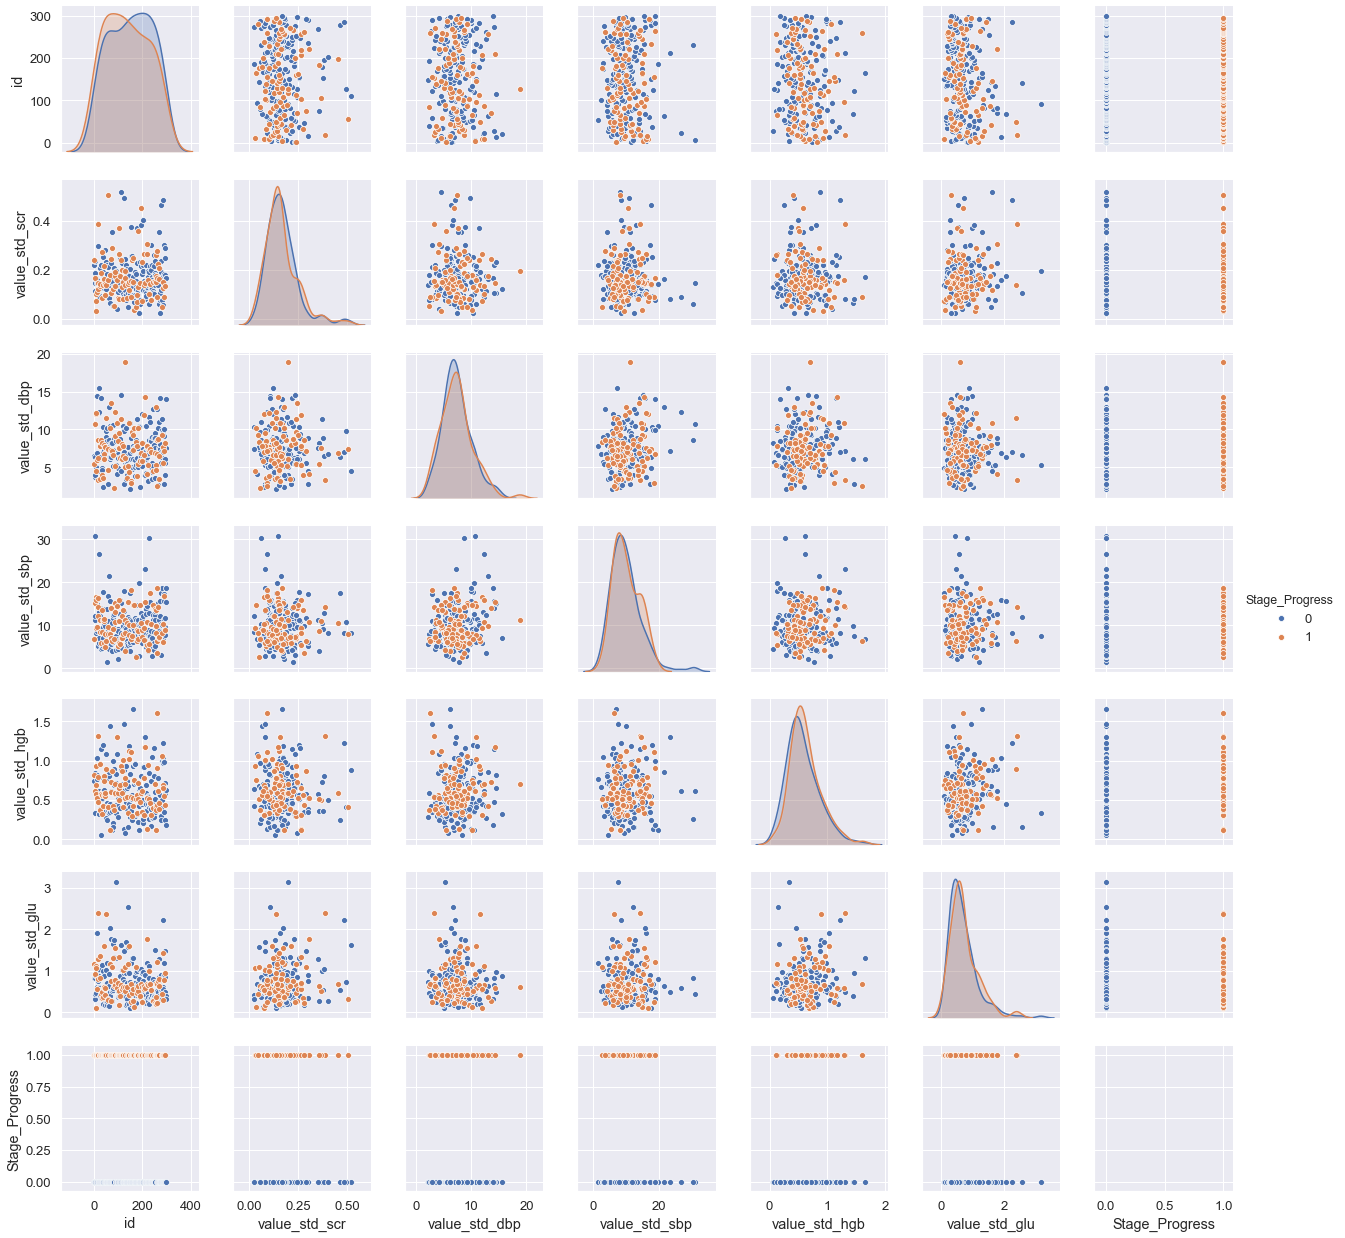

In [411]:
sns.pairplot(subset,hue='Stage_Progress')

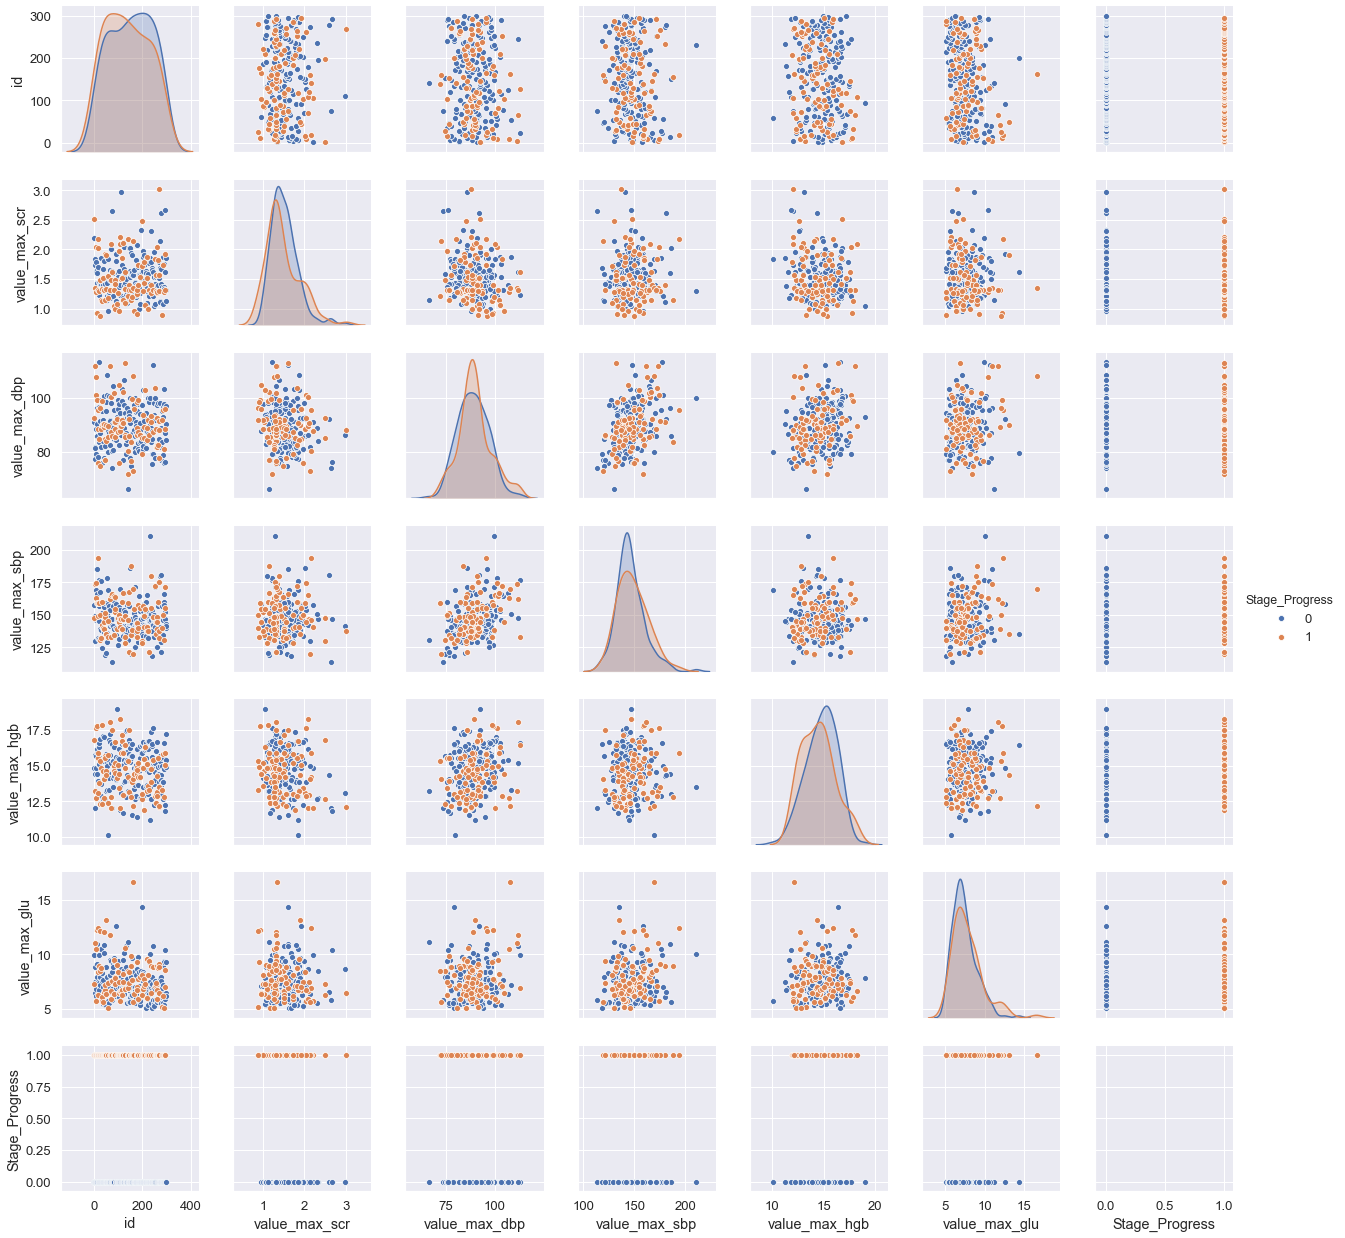

In [412]:
# pairplot for maximum values
subset = df_agg[['id', 'value_max_scr', 'value_max_dbp', 'value_max_sbp', 'value_max_hgb', 'value_max_glu', 
                      'Stage_Progress']]

sns.pairplot(subset,hue='Stage_Progress')

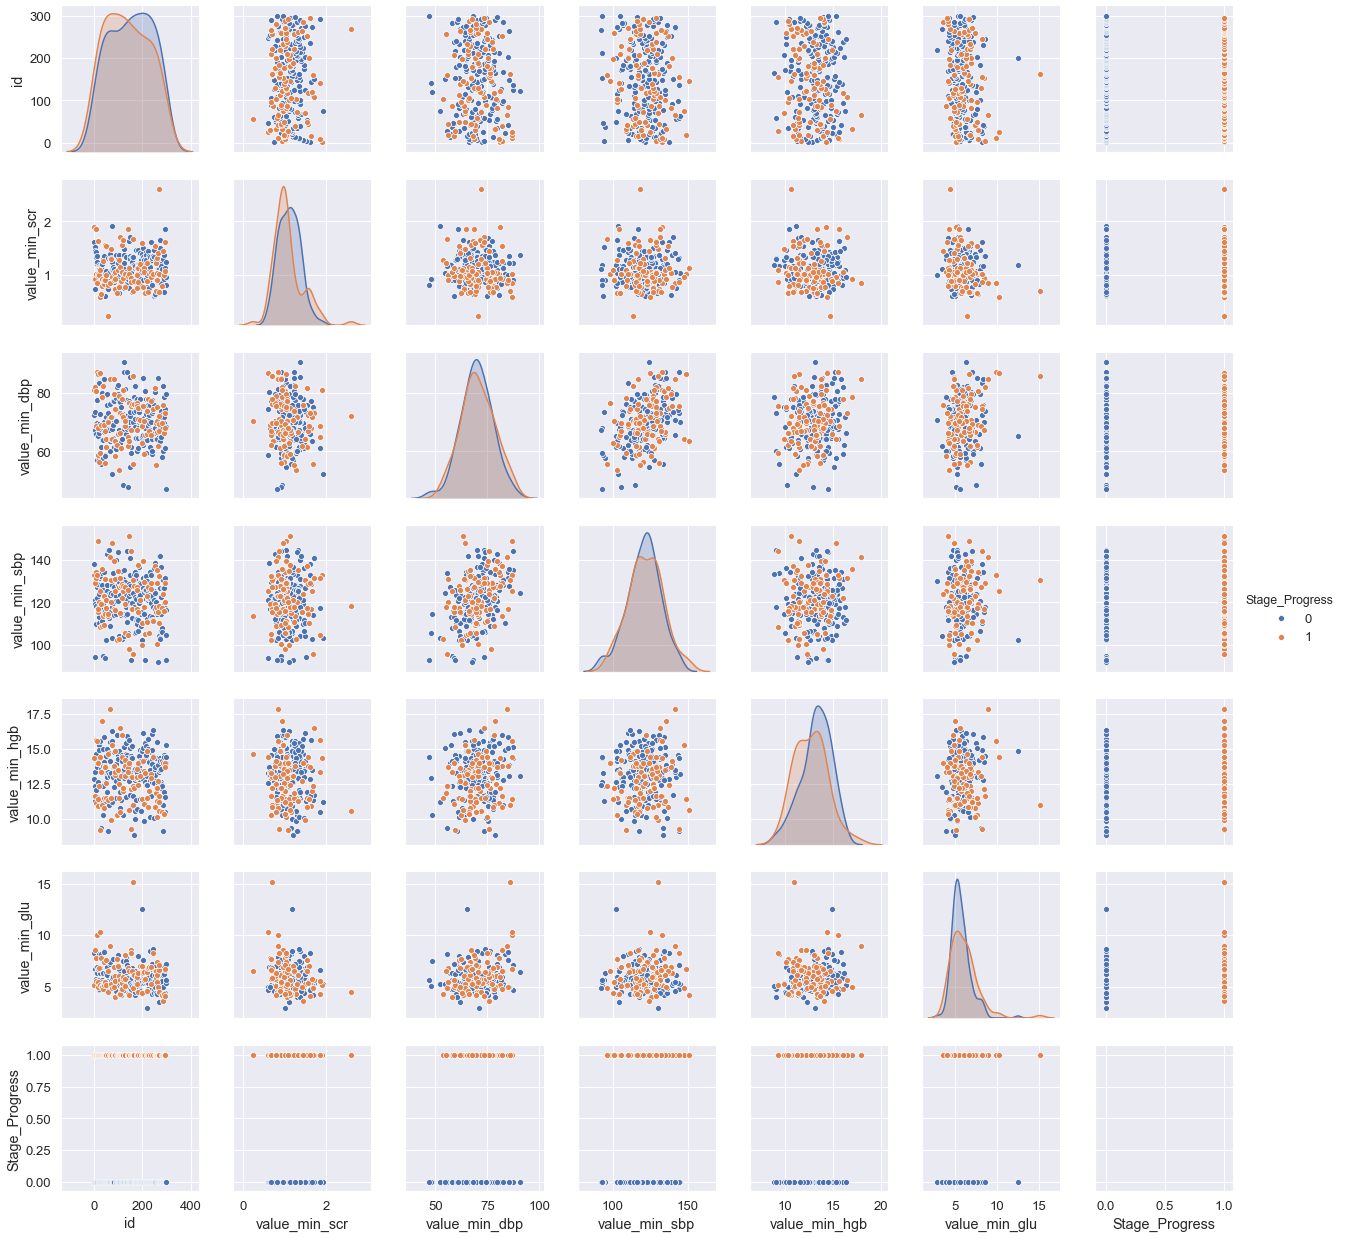

In [413]:
# pairplot for minimum values
subset = df_agg[['id', 'value_min_scr', 'value_min_dbp', 'value_min_sbp', 'value_min_hgb', 'value_min_glu', 
                      'Stage_Progress']]

sns.pairplot(subset,hue='Stage_Progress')

## Model fitting

Again, we fit to the three models we used with the Baseline dataframe.

### i. Logistic Regression

In [414]:
# import libraries
from sklearn.model_selection import train_test_split

In [415]:
df_agg.columns

Index(['id', 'age', 'Male', 'Asian', 'Black', 'Hispanic', 'White',
       'value_mean_scr', 'value_median_scr', 'value_min_scr', 'value_max_scr',
       'value_std_scr', 'time_max_scr', 'value_mean_dbp', 'value_median_dbp',
       'value_min_dbp', 'value_max_dbp', 'value_std_dbp', 'time_max_dbp',
       'value_mean_sbp', 'value_median_sbp', 'value_min_sbp', 'value_max_sbp',
       'value_std_sbp', 'time_max_sbp', 'value_mean_hgb', 'value_median_hgb',
       'value_min_hgb', 'value_max_hgb', 'value_std_hgb', 'time_max_hgb',
       'value_mean_glu', 'value_median_glu', 'value_min_glu', 'value_max_glu',
       'value_std_glu', 'time_max_glu', 'value_mean_ldl', 'value_median_ldl',
       'value_min_ldl', 'value_max_ldl', 'value_std_ldl', 'time_max_ldl',
       'Stage_Progress'],
      dtype='object')

In [416]:
# define X and y
#X = df_agg.drop(['Stage_Progress'], axis=1)
X = df_agg[['id', 'age', 'Male', 'Asian', 'Black', 'Hispanic', 'White', 'value_mean_scr', 'value_mean_dbp', 'value_mean_sbp', 'value_mean_hgb', 'value_mean_glu', 'value_mean_ldl']]
y = df_agg['Stage_Progress']

In [417]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [418]:
# train and fit logistic regression model
from sklearn.linear_model import LogisticRegression

In [419]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [420]:
# predict from model
predictions = logmodel.predict(X_test)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [421]:
# classification report
from sklearn.metrics import classification_report, confusion_matrix

In [422]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[36  2]
 [14  3]]
              precision    recall  f1-score   support

           0       0.72      0.95      0.82        38
           1       0.60      0.18      0.27        17

    accuracy                           0.71        55
   macro avg       0.66      0.56      0.55        55
weighted avg       0.68      0.71      0.65        55



In [423]:
print(logmodel.coef_, logmodel.intercept_)

[[-0.00243244 -0.03543221  0.70221598  0.13837672 -0.08485735 -0.04321791
   0.00241672 -0.19227481  0.00158038  0.01759806 -0.17295503  0.23100728
   0.00441698]] [0.01271818]


Feature: 0, Score: -0.00243
Feature: 1, Score: -0.03543
Feature: 2, Score: 0.70222
Feature: 3, Score: 0.13838
Feature: 4, Score: -0.08486
Feature: 5, Score: -0.04322
Feature: 6, Score: 0.00242
Feature: 7, Score: -0.19227
Feature: 8, Score: 0.00158
Feature: 9, Score: 0.01760
Feature: 10, Score: -0.17296
Feature: 11, Score: 0.23101
Feature: 12, Score: 0.00442


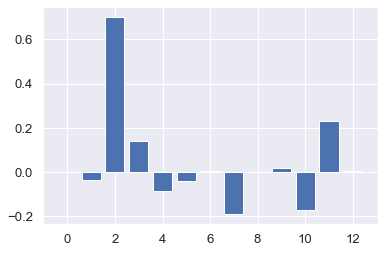

In [424]:
# get importance
importance = logmodel.coef_[0]

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### ii. Decision Tree

In [425]:
from sklearn.tree import DecisionTreeClassifier

In [426]:
dtree = DecisionTreeClassifier()

In [427]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [428]:
predictions = dtree.predict(X_test)

In [429]:
from sklearn.metrics import classification_report,confusion_matrix

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[23 15]
 [ 9  8]]
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        38
           1       0.35      0.47      0.40        17

    accuracy                           0.56        55
   macro avg       0.53      0.54      0.53        55
weighted avg       0.60      0.56      0.58        55



### iii. Random Forest Classifier

In [430]:
from sklearn.ensemble import RandomForestClassifier

In [431]:
rfc = RandomForestClassifier(n_estimators=200)

In [432]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [433]:
rfc_pred = rfc.predict(X_test)

In [434]:
print(confusion_matrix(y_test,rfc_pred))
print(classification_report(y_test,rfc_pred))

[[32  6]
 [15  2]]
              precision    recall  f1-score   support

           0       0.68      0.84      0.75        38
           1       0.25      0.12      0.16        17

    accuracy                           0.62        55
   macro avg       0.47      0.48      0.46        55
weighted avg       0.55      0.62      0.57        55



#### The models seem to perform better with the Aggregated dataset compared to the Baseline dataset. Again, the decision tree classifier performed the best, but the metrics have a lot of room for improvement.

